In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aodnet/pytorch/default/1/AOD_net_epoch_relu_10.pth
/kaggle/input/haze1k/Distributed_haze1k/test_thin/input/043.png
/kaggle/input/haze1k/Distributed_haze1k/test_thin/input/038.png
/kaggle/input/haze1k/Distributed_haze1k/test_thin/input/027.png
/kaggle/input/haze1k/Distributed_haze1k/test_thin/input/007.png
/kaggle/input/haze1k/Distributed_haze1k/test_thin/input/023.png
/kaggle/input/haze1k/Distributed_haze1k/test_thin/input/016.png
/kaggle/input/haze1k/Distributed_haze1k/test_thin/input/005.png
/kaggle/input/haze1k/Distributed_haze1k/test_thin/input/031.png
/kaggle/input/haze1k/Distributed_haze1k/test_thin/input/011.png
/kaggle/input/haze1k/Distributed_haze1k/test_thin/input/013.png
/kaggle/input/haze1k/Distributed_haze1k/test_thin/input/039.png
/kaggle/input/haze1k/Distributed_haze1k/test_thin/input/042.png
/kaggle/input/haze1k/Distributed_haze1k/test_thin/input/024.png
/kaggle/input/haze1k/Distributed_haze1k/test_thin/input/025.png
/kaggle/input/haze1k/Distributed_haze1k

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import math
import torch.optim as optim
from torchvision import transforms, datasets
import os
from PIL import Image

In [3]:
class AODnet(nn.Module):
    def __init__(self):
        super(AODnet, self).__init__()
        self.conv1= nn.Conv2d(in_channels=3, out_channels=3,kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=7, padding=3)
        self.conv5 = nn.Conv2d(in_channels=12, out_channels=3, kernel_size=3, padding=1)
        self.b=1

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        cat1 = torch.cat((x1, x2), 1)
        x3 = F.relu(self.conv3(cat1))
        cat2 = torch.cat((x2, x3), 1)
        x4 = F.relu(self.conv4(cat2))
        cat3 = torch.cat((x1, x2, x3, x4), 1)
        k = F.relu(self.conv5(cat3))

        if k.size() != x.size():
            raise Exception("k, haze image are different size!")

        output = k * x - k + self.b
        return F.relu(output)

In [4]:


class CustomDataset(Dataset):
    def __init__(self, input_folder, target_folder, transform=None):
        self.input_folder = input_folder
        self.target_folder = target_folder
        self.image_list = os.listdir(input_folder)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        input_img_name = os.path.join(self.input_folder, self.image_list[idx])
        target_img_name = os.path.join(self.target_folder, self.image_list[idx])

        input_image = Image.open(input_img_name)
        target_image = Image.open(target_img_name)

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image
# Data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
input_folder = '/kaggle/input/haze1k/Distributed_haze1k/train/input'
target_folder = '/kaggle/input/haze1k/Distributed_haze1k/train/target'

train_dataset = CustomDataset(input_folder=input_folder, target_folder=target_folder, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [5]:
model = AODnet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Move images to GPU if available
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'AODnet.pth')

Epoch [1/100], Loss: 0.1829
Epoch [2/100], Loss: 0.0512
Epoch [3/100], Loss: 0.0404
Epoch [4/100], Loss: 0.0390
Epoch [5/100], Loss: 0.0377
Epoch [6/100], Loss: 0.0363
Epoch [7/100], Loss: 0.0347
Epoch [8/100], Loss: 0.0329
Epoch [9/100], Loss: 0.0310
Epoch [10/100], Loss: 0.0278
Epoch [11/100], Loss: 0.0258
Epoch [12/100], Loss: 0.0245
Epoch [13/100], Loss: 0.0245
Epoch [14/100], Loss: 0.0237
Epoch [15/100], Loss: 0.0240
Epoch [16/100], Loss: 0.0269
Epoch [17/100], Loss: 0.0236
Epoch [18/100], Loss: 0.0220
Epoch [19/100], Loss: 0.0224
Epoch [20/100], Loss: 0.0214
Epoch [21/100], Loss: 0.0229
Epoch [22/100], Loss: 0.0210
Epoch [23/100], Loss: 0.0225
Epoch [24/100], Loss: 0.0245
Epoch [25/100], Loss: 0.0217
Epoch [26/100], Loss: 0.0204
Epoch [27/100], Loss: 0.0211
Epoch [28/100], Loss: 0.0198
Epoch [29/100], Loss: 0.0201
Epoch [30/100], Loss: 0.0201
Epoch [31/100], Loss: 0.0194
Epoch [32/100], Loss: 0.0203
Epoch [33/100], Loss: 0.0197
Epoch [34/100], Loss: 0.0205
Epoch [35/100], Loss: 0

In [7]:
# Assuming the same CustomDataset class is used for the test set
test_input_folder = '/kaggle/input/haze1k/Distributed_haze1k/test_thin/input'
test_target_folder = '/kaggle/input/haze1k/Distributed_haze1k/test_thin/target'

test_dataset = CustomDataset(input_folder=test_input_folder, target_folder=test_target_folder, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the trained model
model = AODnet()
model.load_state_dict(torch.load('AODnet.pth'))
model = model.to(device)

# Evaluation loop
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')


Test Loss: 0.0083


In [8]:
# Assuming the same CustomDataset class is used for the test set
test_input_folder = '/kaggle/input/haze1k/Distributed_haze1k/test_thick/input'
test_target_folder = '/kaggle/input/haze1k/Distributed_haze1k/test_thick/target'

test_dataset = CustomDataset(input_folder=test_input_folder, target_folder=test_target_folder, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the trained model
model = AODnet()
model.load_state_dict(torch.load('AODnet.pth'))
model = model.to(device)

# Evaluation loop
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')


Test Loss: 0.0258


In [9]:
# Assuming the same CustomDataset class is used for the test set
test_input_folder = '/kaggle/input/haze1k/Distributed_haze1k/test_moderate/input'
test_target_folder = '/kaggle/input/haze1k/Distributed_haze1k/test_moderate/target'

test_dataset = CustomDataset(input_folder=test_input_folder, target_folder=test_target_folder, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the trained model
model = AODnet()
model.load_state_dict(torch.load('AODnet.pth'))
model = model.to(device)

# Evaluation loop
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')


Test Loss: 0.0084


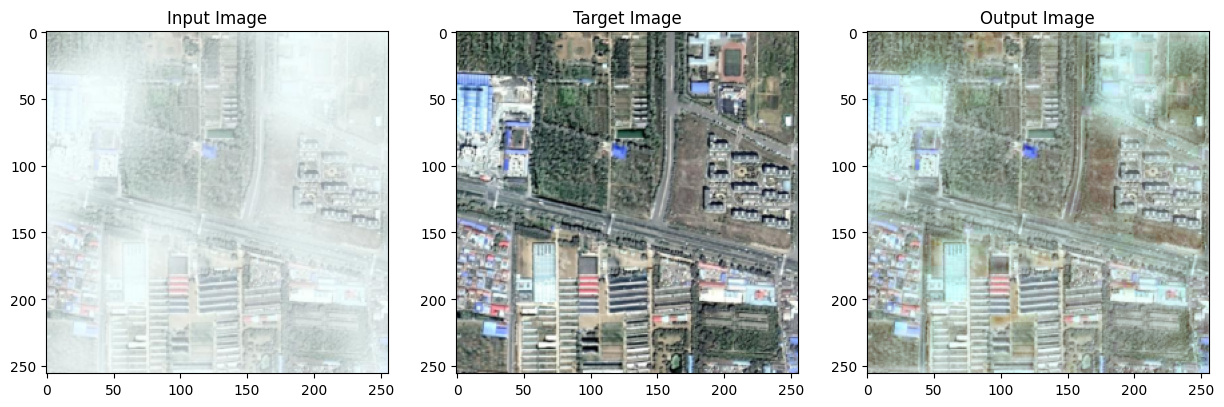

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None):
    """Helper function to display an image."""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Load a single image
input_image_path = '/kaggle/input/haze1k/Distributed_haze1k/test_thick/input/001.png'  # Change to your image path
target_image_path = '/kaggle/input/haze1k/Distributed_haze1k/test_thick/target/001.png'  # Change to your image path

input_image = Image.open(input_image_path)
target_image = Image.open(target_image_path)

# Apply the same transformation as in the dataset
input_image = transform(input_image).unsqueeze(0)  # Add batch dimension
target_image = transform(target_image).unsqueeze(0)  # Add batch dimension

# Move to device
input_image = input_image.to(device)
target_image = target_image.to(device)

# Load the trained model
model = AODnet()
model.load_state_dict(torch.load('AODnet.pth'))
model = model.to(device)

# Set model to evaluation mode
model.eval()

# Get the model output
with torch.no_grad():
    output_image = model(input_image)

# Remove batch dimension and move to CPU
input_image = input_image.squeeze(0).cpu()
target_image = target_image.squeeze(0).cpu()
output_image = output_image.squeeze(0).cpu()

# Convert tensor to numpy array for display
input_image_np = input_image.numpy().transpose((1, 2, 0))
target_image_np = target_image.numpy().transpose((1, 2, 0))
output_image_np = output_image.numpy().transpose((1, 2, 0))

# Display the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_image_np)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(target_image_np)
plt.title('Target Image')

plt.subplot(1, 3, 3)
plt.imshow(output_image_np)
plt.title('Output Image')

plt.show()
